# 13.2a: Topological Evolution During Training

**When does the primordial atom break apart?**

This notebook tracks the evolution of connected components over training time. We compute adjacency graphs at every step and measure:
- Number of connected components
- Size of main component (the "core")
- Escape events (when tokens leave the core)
- Dead vs live token composition in the core

The key question: Does the atom break apart gradually (one token per step), explosively (sudden scatter), or in phases (discrete escape events)?

## Parameters

In [237]:
# Data source
TRAINING_DATA_PATH = "../tensors/Lil_Gatsby/13.1a_training_data.safetensors"

# Topology threshold
DISTANCE_THRESHOLD = 1e-2  # Tokens closer than this are "connected"

# Visualization
DPI = 100
COLORMAP = 'inferno'

RANDOM_SEED = 42

## Imports

In [238]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import safe_open
from collections import deque
from tqdm.auto import tqdm

np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [239]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [240]:
print(f"Loading training data: {TRAINING_DATA_PATH}")

with safe_open(TRAINING_DATA_PATH, framework='pt', device='cpu') as f:
    embeddings_bf16 = f.get_tensor('embeddings')
    dead_token_ids = f.get_tensor('dead_token_ids')
    live_token_ids = f.get_tensor('live_token_ids')
    recorded_steps = f.get_tensor('recorded_steps')

# Convert to float32 and move to device
embeddings = embeddings_bf16.to(torch.float32).to(device)
dead_ids_set = set(dead_token_ids.tolist())
live_ids_set = set(live_token_ids.tolist())

n_steps, n_tokens, n_dims = embeddings.shape

print(f"  Embeddings: {embeddings.shape} ({embeddings.dtype})")
print(f"  Steps: {recorded_steps[0]} to {recorded_steps[-1]}")
print(f"  Dead tokens: {len(dead_token_ids)}")
print(f"  Live tokens: {len(live_token_ids)}")
print(f"\n✓ Data loaded")

Loading training data: ../tensors/Lil_Gatsby/13.1a_training_data.safetensors
  Embeddings: torch.Size([10001, 128, 64]) (torch.float32)
  Steps: 0 to 10000
  Dead tokens: 50
  Live tokens: 78

✓ Data loaded


## Compute Pairwise Distances for All Steps

This is the expensive part, so we do it all at once in a vectorized way.

In [241]:
print(f"Computing pairwise distances for all {n_steps} steps...")
print(f"  Result will be [{n_steps}, {n_tokens}, {n_tokens}] = {n_steps * n_tokens * n_tokens * 4 / 1e9:.2f} GB")

# Process in chunks to avoid OOM
CHUNK_SIZE = 1000
n_chunks = (n_steps + CHUNK_SIZE - 1) // CHUNK_SIZE

distances_all = []

for chunk_idx in tqdm(range(n_chunks), desc="Computing distances"):
    start_idx = chunk_idx * CHUNK_SIZE
    end_idx = min(start_idx + CHUNK_SIZE, n_steps)
    
    # Get embeddings for this chunk: [chunk_size, n_tokens, n_dims]
    chunk_emb = embeddings[start_idx:end_idx]
    
    # Compute pairwise distances for each step in chunk
    # torch.cdist wants [batch, n, dim], gives [batch, n, n]
    chunk_distances = torch.cdist(chunk_emb, chunk_emb, p=2)  # L2 norm
    
    # Move to CPU to save GPU memory
    distances_all.append(chunk_distances.cpu())
    
    # Clear cache
    if device == 'cuda':
        torch.cuda.empty_cache()
    elif device == 'mps':
        torch.mps.empty_cache()

# Concatenate all chunks
distances = torch.cat(distances_all, dim=0)

print(f"\n✓ Distances computed: {distances.shape}")
print(f"  Memory: {distances.element_size() * distances.nelement() / 1e9:.2f} GB")

Computing pairwise distances for all 10001 steps...
  Result will be [10001, 128, 128] = 0.66 GB


Computing distances:   0%|          | 0/11 [00:00<?, ?it/s]


✓ Distances computed: torch.Size([10001, 128, 128])
  Memory: 0.66 GB


## Build Adjacency Graphs

Threshold distances to get boolean adjacency matrices.

In [242]:
print(f"Building adjacency graphs (threshold = {DISTANCE_THRESHOLD})...")

# Simple threshold: distances < DISTANCE_THRESHOLD → connected
adjacency = distances < DISTANCE_THRESHOLD

# Quick sanity check
print(f"\n✓ Adjacency graphs built: {adjacency.shape}")
print(f"  Step 0: {adjacency[0].sum().item()} edges")
print(f"  Step {n_steps-1}: {adjacency[-1].sum().item()} edges")

Building adjacency graphs (threshold = 0.01)...

✓ Adjacency graphs built: torch.Size([10001, 128, 128])
  Step 0: 16384 edges
  Step 10000: 4764 edges


## Find Connected Components at Each Step

BFS to find components. This part is sequential but fast.

In [243]:
def find_components_bfs(adjacency_matrix):
    """
    Find connected components using BFS.
    
    Args:
        adjacency_matrix: [n_tokens, n_tokens] boolean tensor
    
    Returns:
        List of components, each component is a list of token indices
    """
    n = adjacency_matrix.shape[0]
    visited = torch.zeros(n, dtype=torch.bool)
    components = []
    
    for start in range(n):
        if visited[start]:
            continue
        
        # BFS from this token
        component = []
        queue = deque([start])
        visited[start] = True
        
        while queue:
            node = queue.popleft()
            component.append(node)
            
            # Find neighbors
            neighbors = torch.where(adjacency_matrix[node])[0]
            for neighbor in neighbors:
                if not visited[neighbor]:
                    visited[neighbor] = True
                    queue.append(neighbor.item())
        
        components.append(component)
    
    # Sort by size (largest first)
    components.sort(key=len, reverse=True)
    
    return components

print("✓ BFS function defined")

✓ BFS function defined


## Compute Topology Evolution

In [244]:
print(f"Computing topology for all {n_steps} steps...\n")

# Storage
n_components = np.zeros(n_steps, dtype=np.int32)
main_component_size = np.zeros(n_steps, dtype=np.int32)
main_component_dead_count = np.zeros(n_steps, dtype=np.int32)
main_component_live_count = np.zeros(n_steps, dtype=np.int32)
n_singletons = np.zeros(n_steps, dtype=np.int32)

# Loop over all steps
for step_idx in tqdm(range(n_steps), desc="Finding components"):
    components = find_components_bfs(adjacency[step_idx])
    
    # Count components
    n_components[step_idx] = len(components)
    
    # Main component
    if components:
        main = components[0]
        main_component_size[step_idx] = len(main)
        
        # Count dead vs live in main component
        dead_count = sum(1 for tok in main if tok in dead_ids_set)
        live_count = sum(1 for tok in main if tok in live_ids_set)
        main_component_dead_count[step_idx] = dead_count
        main_component_live_count[step_idx] = live_count
    
    # Count singletons
    n_singletons[step_idx] = sum(1 for c in components if len(c) == 1)

print(f"\n✓ Topology computed for all steps")

Computing topology for all 10001 steps...



Finding components:   0%|          | 0/10001 [00:00<?, ?it/s]


✓ Topology computed for all steps


## Summary Statistics

In [245]:
print(f"\n{'='*80}")
print(f"TOPOLOGICAL EVOLUTION SUMMARY")
print(f"{'='*80}\n")

print(f"Step 0 (initialization):")
print(f"  Components: {n_components[0]}")
print(f"  Main component size: {main_component_size[0]} ({main_component_size[0]/n_tokens*100:.1f}%)")
print(f"    Dead: {main_component_dead_count[0]} / {len(dead_token_ids)}")
print(f"    Live: {main_component_live_count[0]} / {len(live_token_ids)}")
print(f"  Singletons: {n_singletons[0]}")

print(f"\nStep {n_steps-1} (final):")
print(f"  Components: {n_components[-1]}")
print(f"  Main component size: {main_component_size[-1]} ({main_component_size[-1]/n_tokens*100:.1f}%)")
print(f"    Dead: {main_component_dead_count[-1]} / {len(dead_token_ids)}")
print(f"    Live: {main_component_live_count[-1]} / {len(live_token_ids)}")
print(f"  Singletons: {n_singletons[-1]}")

# Find first escape event
first_escape = np.where(main_component_size < n_tokens)[0]
if len(first_escape) > 0:
    escape_step = first_escape[0]
    print(f"\nFirst escape: Step {escape_step}")
    print(f"  Main component: {main_component_size[escape_step-1]} → {main_component_size[escape_step]}")
    print(f"  Lost {main_component_size[escape_step-1] - main_component_size[escape_step]} tokens")

# Find biggest drop
drops = -np.diff(main_component_size)
biggest_drop_idx = np.argmax(drops)
print(f"\nBiggest single-step escape: Step {biggest_drop_idx} → {biggest_drop_idx+1}")
print(f"  Main component: {main_component_size[biggest_drop_idx]} → {main_component_size[biggest_drop_idx+1]}")
print(f"  Lost {drops[biggest_drop_idx]} tokens")

print(f"\n{'='*80}")


TOPOLOGICAL EVOLUTION SUMMARY

Step 0 (initialization):
  Components: 1
  Main component size: 128 (100.0%)
    Dead: 50 / 50
    Live: 78 / 78
  Singletons: 0

Step 10000 (final):
  Components: 45
  Main component size: 72 (56.2%)
    Dead: 50 / 50
    Live: 22 / 78
  Singletons: 37

First escape: Step 5
  Main component: 128 → 126
  Lost 2 tokens

Biggest single-step escape: Step 1819 → 1820
  Main component: 95 → 79
  Lost 16 tokens



## Visualizations

### Number of Components Over Time

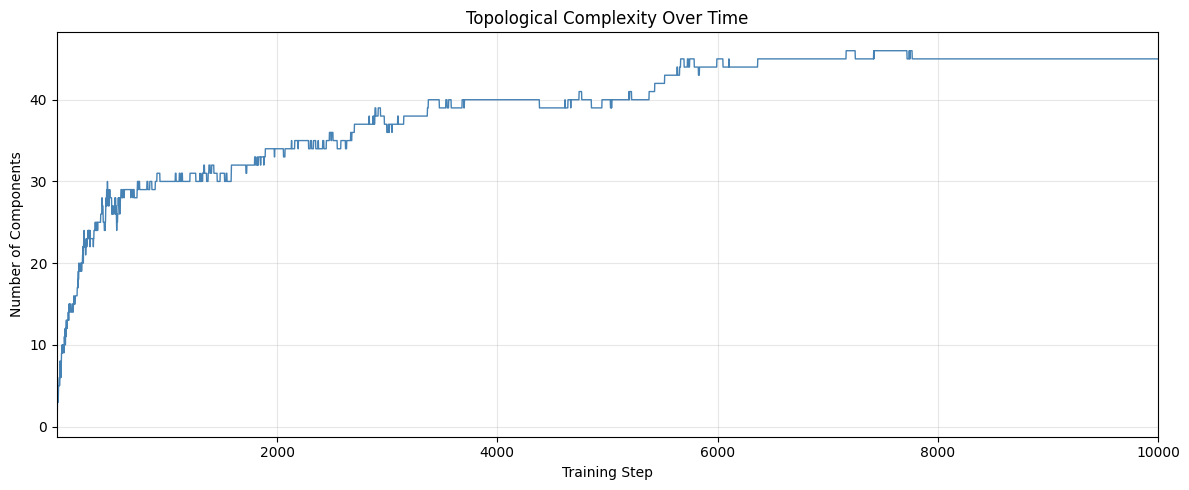

In [246]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=DPI)

ax.plot(recorded_steps.numpy(), n_components, linewidth=1, color='steelblue')
ax.set_xlabel('Training Step')
ax.set_ylabel('Number of Components')
ax.set_title('Topological Complexity Over Time')
ax.grid(True, alpha=0.3)
ax.set_xscale('linear')
ax.set_xlim(1, 10000)
ax.set_aspect('auto')

plt.tight_layout()
plt.show()

### Main Component Size Over Time

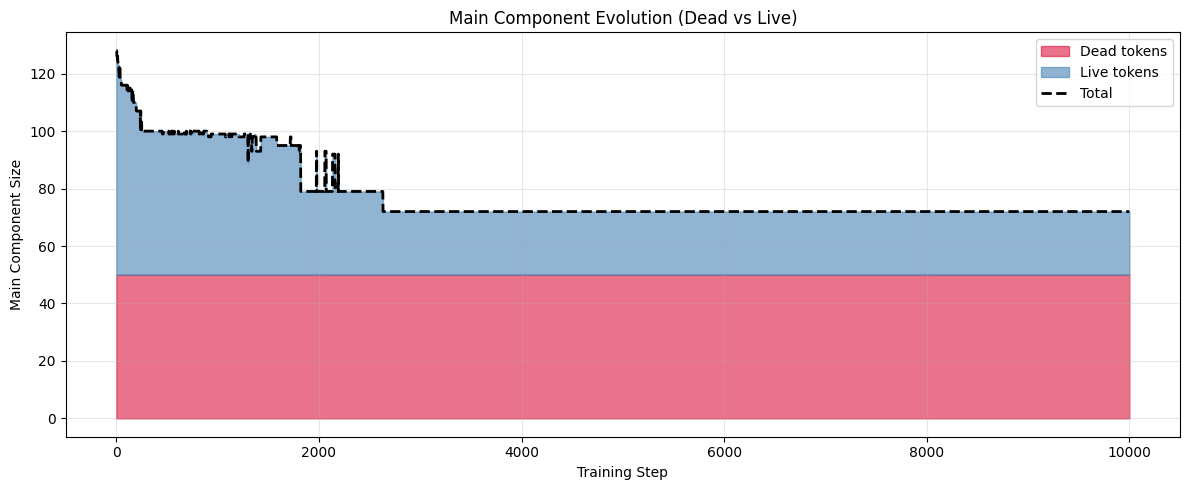

In [247]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=DPI)

# Stacked area for dead/live composition
ax.fill_between(recorded_steps.numpy(), 0, main_component_dead_count, 
                label='Dead tokens', color='crimson', alpha=0.6)
ax.fill_between(recorded_steps.numpy(), main_component_dead_count, 
                main_component_dead_count + main_component_live_count,
                label='Live tokens', color='steelblue', alpha=0.6)

# Total size line
ax.plot(recorded_steps.numpy(), main_component_size, linewidth=2, 
        color='black', label='Total', linestyle='--')

ax.set_xlabel('Training Step')
ax.set_ylabel('Main Component Size')
ax.set_title('Main Component Evolution (Dead vs Live)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Singletons Over Time

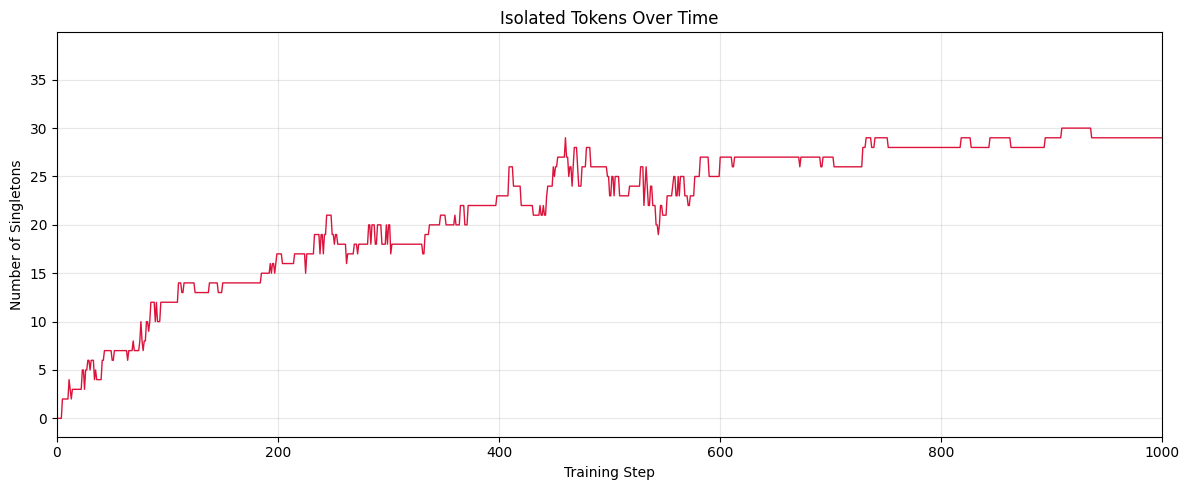

In [248]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=DPI)

ax.plot(recorded_steps.numpy(), n_singletons, linewidth=1, color='crimson')
ax.set_xlabel('Training Step')
ax.set_ylabel('Number of Singletons')
ax.set_title('Isolated Tokens Over Time')
ax.grid(True, alpha=0.3)
ax.set_xscale('linear')
ax.set_xlim(0, 1000)
ax.set_aspect('auto')

plt.tight_layout()
plt.show()

### Escape Rate (Negative Derivative)

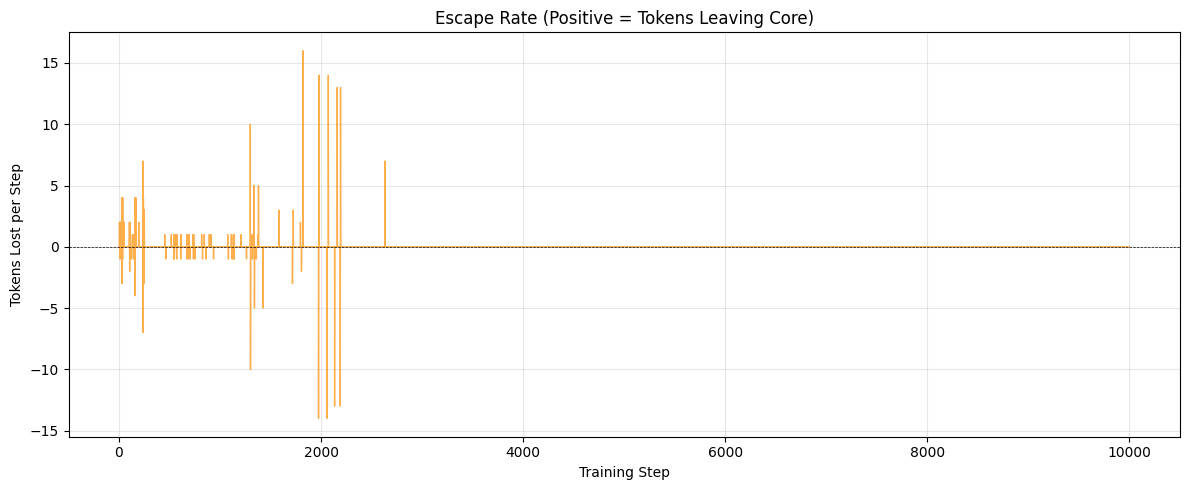

In [249]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=DPI)

# Negative derivative = escape rate
escape_rate = -np.diff(main_component_size)
steps_diff = recorded_steps.numpy()[1:]

ax.plot(steps_diff, escape_rate, linewidth=1, color='darkorange', alpha=0.7)
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.set_xlabel('Training Step')
ax.set_ylabel('Tokens Lost per Step')
ax.set_title('Escape Rate (Positive = Tokens Leaving Core)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Done

In [250]:
print("✓ Analysis complete")

✓ Analysis complete
